In [ ]:
from tqdm import tqdm
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# create temp file and save converted embedding into it
target_file = get_tmpfile('C:/Users/fahan/Desktop/CENTELLA/NLP/GoogleNews-vectors-negative300.bin')
glove2word2vec('C:/Users/fahan/Desktop/CENTELLA/NLP/NLP/glove/glove.6B.100d.txt', target_file)

# load the converted embedding into memory
model = KeyedVectors.load_word2vec_format(target_file)

# save as binary data
model.save_word2vec_format('word2vec.6B.100d.bin.gz', binary=True)

<ipython-input-2-84317ad95d1d>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec('C:/Users/fahan/Desktop/CENTELLA/NLP/NLP/glove/glove.6B.100d.txt', target_file)


In [ ]:
model.most_similar('king')

[('prince', 0.7682329416275024),
 ('queen', 0.7507690787315369),
 ('son', 0.7020888328552246),
 ('brother', 0.6985775828361511),
 ('monarch', 0.6977890729904175),
 ('throne', 0.691999077796936),
 ('kingdom', 0.6811409592628479),
 ('father', 0.6802029013633728),
 ('emperor', 0.6712858080863953),
 ('ii', 0.6676074266433716)]

In [ ]:
data = pd.read_csv('data/file_information.csv')

In [ ]:
numerical_categories = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}

for key, val in numerical_categories.items():
    data = data.replace(key, val)
        
# add class labels 
data['Class'] = np.where(data['Category'] != 0, 1, 0) # label whether plagiarized (1) or not (0)
data['Class'] = np.where(data['Category'] == -1, -1, data['Class']) # -1 category is origin => class is -1 (meaningless)

In [ ]:
def process_file(file):
    # put text in all lower case letters 
    all_text = file.read().lower()

    # remove all non-alphanumeric chars
    all_text = re.sub(r"[^a-zA-Z0-9]", " ", all_text)
    # remove newlines/tabs, etc. so it's easier to match phrases, later
    all_text = re.sub(r"\t", " ", all_text)
    all_text = re.sub(r"\n", " ", all_text)
    all_text = re.sub("  ", " ", all_text)
    all_text = re.sub("   ", " ", all_text)
    
    return all_text

In [ ]:
#Add processed text as a new column
texts = []
for index, row in data.iterrows():
    filename = 'data/'+row['File']
    with open(filename, 'r', encoding='utf-8', errors='ignore') as fh:
        processed_text = process_file(fh)
        texts.append(processed_text)
data['Text'] = texts

In [ ]:
data.head()

,File,Task,Category,Class,Text
0,g0pA_taska.txt,a,0,0,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,2,1,the vector space model also called term vector...
3,g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design tec...


In [ ]:
orig = data[data['Class'] == -1]
answers = data[data['Class']!=-1]
X = answers.drop(columns='Class')
y = answers['Class']
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.3,stratify=y,random_state=10)


In [ ]:
stop_words=stopwords.words('english')
def glove_distance(query,source,query_index,source_index):
     
    query_list=[word for word in query['Text'].iloc[query_index] if word not in stop_words] 
    
    source_list=[word for word in source['Text'].iloc[source_index] if word not in stop_words] 
    #print(source_list)
    dist=model.wmdistance(query_list,source_list)
    return dist

In [ ]:
glove_dist_array=np.empty((len(train_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(train_X))):
        glove_dist_array[j][i]=glove_distance(train_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 25.87it/s]


In [ ]:
glove_distance(answers,orig,5,0)

0.14735764109355948

In [ ]:
glove_dist_array

array([[0.0964263 , 0.09508124, 0.10418162, 0.10469788, 0.07013668],
       [0.03523616, 0.11846354, 0.08238397, 0.09380507, 0.10110582],
       [0.11660871, 0.12929968, 0.13435769, 0.0914349 , 0.06426386],
       [0.09623823, 0.10521392, 0.09236886, 0.11300733, 0.06318842],
       [0.09656336, 0.06443249, 0.11352832, 0.11234194, 0.07797243],
       [0.07339576, 0.0876809 , 0.09279246, 0.08378799, 0.05125997],
       [0.12914023, 0.16441648, 0.09745327, 0.16255294, 0.15281115],
       [0.11091655, 0.1412329 , 0.07494395, 0.1386258 , 0.12419111],
       [0.11279571, 0.06241374, 0.13454233, 0.12120714, 0.08773824],
       [0.11758414, 0.10700975, 0.12332865, 0.10181381, 0.05471764],
       [0.10859991, 0.11841197, 0.12076365, 0.03994491, 0.09178451],
       [0.0488812 , 0.12174659, 0.05577911, 0.11136551, 0.11740454],
       [0.0702253 , 0.12564954, 0.08565366, 0.13425829, 0.11699921],
       [0.12057655, 0.07161696, 0.1368041 , 0.14458551, 0.1234264 ],
       [0.11506811, 0.06598635, 0.

In [ ]:
train_min_dist = glove_dist_array.min(axis=1)
train_min_dist

array([0.07013668, 0.03523616, 0.06426386, 0.06318842, 0.06443249,
       0.05125997, 0.09745327, 0.07494395, 0.06241374, 0.05471764,
       0.03994491, 0.0488812 , 0.0702253 , 0.07161696, 0.06598635,
       0.02988604, 0.08410055, 0.0315537 , 0.088884  , 0.04179806,
       0.06262134, 0.07690771, 0.0904376 , 0.12558125, 0.00500487,
       0.04728627, 0.08982674, 0.04217923, 0.06712285, 0.07330327,
       0.10325531, 0.07974428, 0.06813218, 0.07218738, 0.08222513,
       0.05619073, 0.05290574, 0.09236159, 0.025212  , 0.05300166,
       0.04473874, 0.07318906, 0.03983008, 0.08284432, 0.0508378 ,
       0.06916588, 0.09007992, 0.06727171, 0.10240427, 0.05519572,
       0.06394967, 0.00851662, 0.03654777, 0.08637822, 0.11059557,
       0.07267021, 0.04734345, 0.10850133, 0.08194402, 0.10613369,
       0.04501592, 0.053956  , 0.01520622, 0.06955542, 0.03611116,
       0.07726147])

In [ ]:
dist_scaler=MinMaxScaler().fit(train_min_dist.reshape(-1,1))

In [ ]:
train_min_dist_norm=dist_scaler.transform(train_min_dist.reshape(-1,1))
train_min_dist_norm

array([[0.54017057],
       [0.25072316],
       [0.49146429],
       [0.4825452 ],
       [0.49286285],
       [0.38361657],
       [0.76672065],
       [0.58003965],
       [0.47612039],
       [0.41229276],
       [0.28977517],
       [0.36388823],
       [0.54090551],
       [0.55244723],
       [0.50574979],
       [0.20635188],
       [0.6559799 ],
       [0.22018267],
       [0.69565141],
       [0.3051442 ],
       [0.47784209],
       [0.59632605],
       [0.70853624],
       [1.        ],
       [0.        ],
       [0.35066073],
       [0.70347005],
       [0.30830545],
       [0.51517538],
       [0.56643269],
       [0.81483987],
       [0.61985115],
       [0.52354622],
       [0.55717804],
       [0.64042613],
       [0.42450986],
       [0.39726577],
       [0.7244928 ],
       [0.16758774],
       [0.39806129],
       [0.32953273],
       [0.56548546],
       [0.28882279],
       [0.64556137],
       [0.38011532],
       [0.53211923],
       [0.70556979],
       [0.516

In [ ]:
train_glove_similarity=1-train_min_dist_norm
train_glove_similarity

array([[4.59829434e-01],
       [7.49276843e-01],
       [5.08535712e-01],
       [5.17454799e-01],
       [5.07137151e-01],
       [6.16383428e-01],
       [2.33279349e-01],
       [4.19960346e-01],
       [5.23879610e-01],
       [5.87707245e-01],
       [7.10224825e-01],
       [6.36111772e-01],
       [4.59094492e-01],
       [4.47552774e-01],
       [4.94250208e-01],
       [7.93648121e-01],
       [3.44020105e-01],
       [7.79817333e-01],
       [3.04348587e-01],
       [6.94855796e-01],
       [5.22157914e-01],
       [4.03673947e-01],
       [2.91463757e-01],
       [1.11022302e-16],
       [1.00000000e+00],
       [6.49339270e-01],
       [2.96529947e-01],
       [6.91694553e-01],
       [4.84824619e-01],
       [4.33567313e-01],
       [1.85160128e-01],
       [3.80148854e-01],
       [4.76453781e-01],
       [4.42821957e-01],
       [3.59573870e-01],
       [5.75490143e-01],
       [6.02734233e-01],
       [2.75507197e-01],
       [8.32412260e-01],
       [6.01938714e-01],


<AxesSubplot:xlabel='Category'>

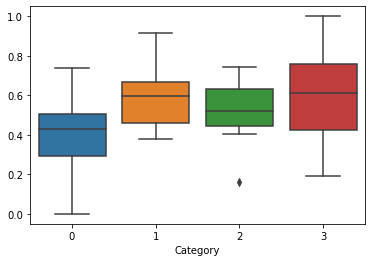

In [ ]:
sns.boxplot(x=train_X['Category'],y=train_glove_similarity.ravel())

In [ ]:
roc_auc_score(train_y,train_glove_similarity.ravel())

0.7451923076923077

In [ ]:
fpr,tpr,threshold = roc_curve(train_y,train_glove_similarity.ravel())
print("fpr:",fpr,"\n")
print("tpr:",tpr,"\n")
print("threshold",threshold,"\n")


fpr: [0.         0.         0.         0.03846154 0.03846154 0.07692308
 0.07692308 0.11538462 0.11538462 0.15384615 0.15384615 0.19230769
 0.19230769 0.23076923 0.23076923 0.30769231 0.30769231 0.34615385
 0.34615385 0.38461538 0.38461538 0.42307692 0.42307692 0.46153846
 0.46153846 0.5        0.5        0.53846154 0.53846154 0.57692308
 0.57692308 0.76923077 0.76923077 0.84615385 0.84615385 0.88461538
 0.88461538 1.        ] 

tpr: [0.    0.025 0.2   0.2   0.25  0.25  0.325 0.325 0.525 0.525 0.55  0.55
 0.6   0.6   0.625 0.625 0.65  0.65  0.675 0.675 0.7   0.7   0.725 0.725
 0.75  0.75  0.8   0.8   0.875 0.875 0.925 0.925 0.95  0.95  0.975 0.975
 1.    1.   ] 

threshold [2.00000000e+00 1.00000000e+00 7.42020072e-01 7.38399027e-01
 7.10224825e-01 6.94855796e-01 6.68168424e-01 6.49339270e-01
 5.87707245e-01 5.83742313e-01 5.75490143e-01 5.23879610e-01
 5.17454799e-01 5.11141443e-01 5.08535712e-01 4.94250208e-01
 4.84824619e-01 4.83590108e-01 4.76453781e-01 4.67880773e-01
 4.64650108e-

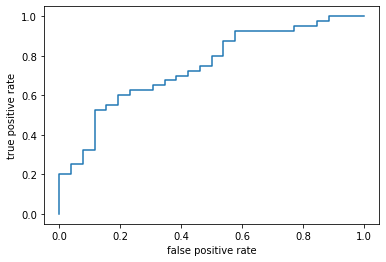

In [ ]:
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr,tpr)

In [ ]:
# get the best threshold using Youden’s J statistic.
J = tpr - fpr
ix = np.argmax(J)
best_thresh = threshold[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.587707


In [ ]:
train_Y_Pred=np.where(train_glove_similarity.ravel()>best_thresh,1,0)
train_Y_Pred

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
# training accuracy
accuracy_train= accuracy_score(train_y,train_Y_Pred)
print("Training Accuracy:",accuracy_train)

Training Accuracy: 0.6515151515151515


In [ ]:
glove_test_dist_array=np.empty((len(test_X),len(orig)))
for i in (range(len(orig))):
    for j in tqdm(range(len(test_X))):
        glove_test_dist_array[j][i]=glove_distance(test_X,orig,j,i)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 27.61it/s]


In [ ]:
glove_test_dist_array

array([[0.10307557, 0.09980036, 0.07925146, 0.13265277, 0.0802286 ],
       [0.08740785, 0.11934407, 0.04651287, 0.11487899, 0.10425372],
       [0.14583415, 0.16914068, 0.15189831, 0.0828533 , 0.13852182],
       [0.11664315, 0.1108268 , 0.13851149, 0.13037432, 0.06776663],
       [0.07178924, 0.13103324, 0.0921514 , 0.12795289, 0.12680999],
       [0.09269351, 0.11892914, 0.04863439, 0.12105917, 0.13404003],
       [0.06669974, 0.10785236, 0.01488689, 0.10297784, 0.10613107],
       [0.07407814, 0.10936024, 0.02887273, 0.10419005, 0.09517421],
       [0.06497661, 0.10981509, 0.06625297, 0.09079552, 0.08286803],
       [0.09443533, 0.11995242, 0.03626695, 0.12054532, 0.10952633],
       [0.10240098, 0.03871346, 0.12146895, 0.12449769, 0.09582346],
       [0.08367093, 0.08687791, 0.08111925, 0.11777102, 0.09666362],
       [0.10803457, 0.14691998, 0.11469184, 0.13492792, 0.1344026 ],
       [0.04922007, 0.09599959, 0.08431027, 0.09575425, 0.06063052],
       [0.09739312, 0.06380667, 0.

In [ ]:
min_glove_test_dist_array=glove_test_dist_array.min(axis=1)
min_glove_test_dist_array

array([0.07925146, 0.04651287, 0.0828533 , 0.06776663, 0.07178924,
       0.04863439, 0.01488689, 0.02887273, 0.06497661, 0.03626695,
       0.03871346, 0.08111925, 0.10803457, 0.04922007, 0.06380667,
       0.04310008, 0.00461129, 0.07191834, 0.06978511, 0.06118599,
       0.08818581, 0.05945231, 0.05533351, 0.03681374, 0.06167512,
       0.04979157, 0.0366759 , 0.05798536, 0.09569141])

In [ ]:
test_min_dist_norm=dist_scaler.transform(min_glove_test_dist_array.reshape(-1,1))
test_glove_sim=1-test_min_dist_norm
test_glove_sim

array([[0.38423599],
       [0.65575347],
       [0.35436421],
       [0.47948545],
       [0.44612395],
       [0.63815865],
       [0.91804356],
       [0.80205199],
       [0.50262448],
       [0.740728  ],
       [0.72043789],
       [0.36874549],
       [0.14552334],
       [0.63330133],
       [0.51232735],
       [0.68405746],
       [1.00326417],
       [0.44505327],
       [0.46274523],
       [0.53406203],
       [0.31013903],
       [0.54844023],
       [0.58259954],
       [0.73619324],
       [0.53000538],
       [0.62856161],
       [0.73733637],
       [0.56060637],
       [0.2478913 ]])

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Glove_Similarity')]

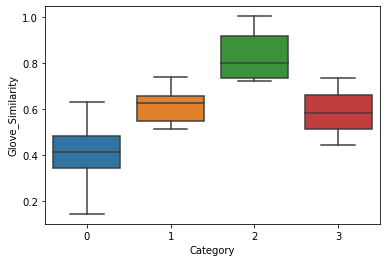

In [ ]:
box_plot=sns.boxplot(x=test_X['Category'],y=test_glove_sim.ravel())
box_plot.set(xlabel='Category',ylabel='Glove_Similarity')

In [ ]:
roc_auc_score(test_y,test_glove_sim)

0.9362745098039215

In [ ]:
test_Y_Pred=np.where(test_glove_sim.ravel()>best_thresh,1,0)
test_Y_Pred

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0])

In [ ]:
test_y,test_Y_Pred

(72    0
 47    1
 23    0
 44    0
 50    1
 17    1
 42    1
 2     1
 93    0
 32    1
 91    1
 76    0
 22    0
 64    0
 21    1
 61    1
 20    1
 71    0
 40    0
 65    0
 38    0
 90    1
 36    1
 49    1
 39    1
 89    1
 48    1
 53    1
 0     0
 Name: Class, dtype: int32,
 array([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 0]))

In [ ]:
# test accuracy
test_accuracy= accuracy_score(test_y,test_Y_Pred)
print("Test Accuracy:",test_accuracy)

Test Accuracy: 0.7586206896551724


In [ ]:
glove_test_y_cat_1=test_y[test_X['Category']==0]
glove_test_y_Pred_cat_1=test_Y_Pred[test_X['Category']==0]
glove_test_y_cat_2=test_y[test_X['Category']==1]
glove_test_y_Pred_cat_2=test_Y_Pred[test_X['Category']==1]
glove_test_y_cat_3=test_y[test_X['Category']==2]
glove_test_y_Pred_cat_3=test_Y_Pred[test_X['Category']==2]
glove_test_y_cat_4=test_y[test_X['Category']==3]
glove_test_y_Pred_cat_4=test_Y_Pred[test_X['Category']==3]


In [ ]:
glove_train_y_cat_1=train_y[train_X['Category']==0]
glove_train_y_Pred_cat_1=train_Y_Pred[train_X['Category']==0]
glove_train_y_cat_2=train_y[train_X['Category']==1]
glove_train_y_Pred_cat_2=train_Y_Pred[train_X['Category']==1]
glove_train_y_cat_3=train_y[train_X['Category']==2]
glove_train_y_Pred_cat_3=train_Y_Pred[train_X['Category']==2]
glove_train_y_cat_4=train_y[train_X['Category']==3]
glove_train_y_Pred_cat_4=train_Y_Pred[train_X['Category']==3]

In [ ]:
# test accuracy
glove_test_accuracy_cat_1= accuracy_score(glove_test_y_cat_1,glove_test_y_Pred_cat_1)
print("Test Accuracy Category 1:",glove_test_accuracy_cat_1)
glove_test_accuracy_cat_2= accuracy_score(glove_test_y_cat_2,glove_test_y_Pred_cat_2)
print("Test Accuracy Category 1:",glove_test_accuracy_cat_2)
glove_test_accuracy_cat_3= accuracy_score(glove_test_y_cat_3,glove_test_y_Pred_cat_3)
print("Test Accuracy Category 1:",glove_test_accuracy_cat_3)
glove_test_accuracy_cat_4= accuracy_score(glove_test_y_cat_4,glove_test_y_Pred_cat_4)
print("Test Accuracy Category 1:",glove_test_accuracy_cat_4)


Test Accuracy Category 1: 0.9166666666666666
Test Accuracy Category 1: 0.5555555555555556
Test Accuracy Category 1: 1.0
Test Accuracy Category 1: 0.3333333333333333


In [ ]:
# train accuracy
glove_train_acc_cat_1=accuracy_score(glove_train_y_cat_1,glove_train_y_Pred_cat_1)
print("Train Accuracy Category 1:",glove_train_acc_cat_1)
glove_train_acc_cat_2=accuracy_score(glove_train_y_cat_2,glove_train_y_Pred_cat_2)
print("Train Accuracy Category 2:",glove_train_acc_cat_2)
glove_train_acc_cat_3=accuracy_score(glove_train_y_cat_3,glove_train_y_Pred_cat_3)
print("Train Accuracy Category 3:",glove_train_acc_cat_3)
glove_train_acc_cat_4=accuracy_score(glove_train_y_cat_4,glove_train_y_Pred_cat_4)
print("Train Accuracy Category 4:",glove_train_acc_cat_4)

Train Accuracy Category 1: 0.8846153846153846
Train Accuracy Category 2: 0.5
Train Accuracy Category 3: 0.35714285714285715
Train Accuracy Category 4: 0.625


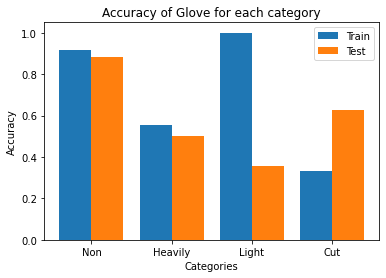

In [ ]:
X =  ['Non','Heavily','Light','Cut']
Train_Accuracy = [glove_test_accuracy_cat_1,glove_test_accuracy_cat_2,glove_test_accuracy_cat_3,glove_test_accuracy_cat_4]
Test_Accuracy = [glove_train_acc_cat_1,glove_train_acc_cat_2,glove_train_acc_cat_3,glove_train_acc_cat_4]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Train_Accuracy, 0.4, label = 'Train')
plt.bar(X_axis + 0.2, Test_Accuracy, 0.4, label = 'Test')
  
plt.xticks(X_axis, X)
plt.xlabel("Categories")
plt.ylabel("Accuracy")
plt.title("Accuracy of Glove for each category")
plt.legend()
plt.show()